In [1]:
pip install opencv-python mediapipe matplotlib scikit-learn numpy IPython googletrans==4.0.0-rc1


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.0 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17397 sha256=f9891e13f9d0ebb589ed0eecbaaa0f724eb49a70c79082004b0cf5ea033942ae
  Stored in directory: /root/.cache/pip/wheels/39/17/6f/66a045ea3d168826074691b4b787b8f324d3

In [2]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Javascript, Image, clear_output
from google.colab.output import eval_js
from base64 import b64decode
import pickle
import random
from sklearn.ensemble import RandomForestClassifier
import time
import os
from googletrans import Translator

In [13]:
# Cell 3: Setup webcam access in Colab
# --------------------------------
def take_photo(filename='photo.jpg', quality=0.8):
    """Use JavaScript to capture an image from the webcam in Google Colab."""
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      const video = document.createElement('video');
      const canvas = document.createElement('canvas');

      div.style.textAlign = 'center';
      div.style.marginTop = '20px';
      video.style.display = 'block';
      video.style.margin = '0 auto';
      video.style.border = '1px solid black';
      video.style.transform = 'scaleX(-1)'; // Mirror image horizontally
      capture.textContent = 'Capture';
      capture.style.display = 'block';
      capture.style.margin = '10px auto';
      capture.style.padding = '10px 20px';
      capture.style.backgroundColor = '#4CAF50';
      capture.style.color = 'white';
      capture.style.border = 'none';
      capture.style.borderRadius = '5px';
      capture.style.fontSize = '16px';
      capture.style.cursor = 'pointer';

      div.appendChild(video);
      div.appendChild(capture);
      document.body.appendChild(div);

      const constraints = {
        video: {
          facingMode: "user",
          width: { ideal: 640 },
          height: { ideal: 480 }
        }
      };

      const stream = await navigator.mediaDevices.getUserMedia(constraints);
      video.srcObject = stream;
      video.play();

      return new Promise((resolve) => {
        capture.onclick = () => {
          canvas.width = video.videoWidth;
          canvas.height = video.videoHeight;
          canvas.getContext('2d').drawImage(video, 0, 0);
          stream.getVideoTracks()[0].stop();
          div.remove();
          resolve(canvas.toDataURL('image/jpeg', quality));
        };
      });
    }
    ''')

    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename


In [14]:
# Cell 4: Setup hand tracking with MediaPipe
# --------------------------------
class HandTracker:
    """Tracks hand landmarks using MediaPipe Hands."""

    def __init__(self):
        self.mp_hands = mp.solutions.hands
        self.hands = self.mp_hands.Hands(
            static_image_mode=True,
            max_num_hands=1,
            min_detection_confidence=0.5
        )
        self.mp_drawing = mp.solutions.drawing_utils
        self.mp_drawing_styles = mp.solutions.drawing_styles

    def detect_landmarks(self, image):
        """Detect hand landmarks in the image."""
        # Convert the BGR image to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Process the image and detect hands
        results = self.hands.process(image_rgb)

        return results

    def draw_landmarks(self, image, results):
        """Draw the detected landmarks on the image."""
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                self.mp_drawing.draw_landmarks(
                    image,
                    hand_landmarks,
                    self.mp_hands.HAND_CONNECTIONS,
                    self.mp_drawing_styles.get_default_hand_landmarks_style(),
                    self.mp_drawing_styles.get_default_hand_connections_style())
        return image

    def get_landmark_coordinates(self, results):
        """Extract normalized coordinates of hand landmarks."""
        if not results.multi_hand_landmarks:
            return None

        # Get the first detected hand
        hand_landmarks = results.multi_hand_landmarks[0]

        # Extract coordinates for each landmark
        landmarks = []
        for landmark in hand_landmarks.landmark:
            # Keep normalized coordinates (they work better for recognition)
            x = landmark.x
            y = landmark.y
            z = landmark.z
            landmarks.append([x, y, z])

        return np.array(landmarks)

    def extract_features(self, landmarks):
        """Extract hand gesture features from landmarks for classification."""
        if landmarks is None:
            return None

        # Flatten the landmarks array for ML model input
        flattened = landmarks.flatten()

        # Calculate additional features (optional but helpful)
        features = []
        features.extend(flattened)  # Add all landmark coordinates

        # Normalize relative to wrist position
        wrist = landmarks[0]
        for i in range(1, 21):  # 21 landmarks total
            # Add distance from wrist to each landmark
            dist = np.sqrt(
                (landmarks[i][0] - wrist[0])**2 +
                (landmarks[i][1] - wrist[1])**2
            )
            features.append(dist)

        # Calculate angles between key finger joints
        # Thumb: 1-4, Index: 5-8, Middle: 9-12, Ring: 13-16, Pinky: 17-20

        # Calculate finger extensions
        thumb_ext = self._calculate_extension(landmarks, 1, 2, 3, 4)
        index_ext = self._calculate_extension(landmarks, 5, 6, 7, 8)
        middle_ext = self._calculate_extension(landmarks, 9, 10, 11, 12)
        ring_ext = self._calculate_extension(landmarks, 13, 14, 15, 16)
        pinky_ext = self._calculate_extension(landmarks, 17, 18, 19, 20)

        features.extend([thumb_ext, index_ext, middle_ext, ring_ext, pinky_ext])

        return np.array(features)

    def _calculate_extension(self, landmarks, base_idx, mid1_idx, mid2_idx, tip_idx):
        """Calculate how extended a finger is (1.0 = fully extended, 0.0 = curled)"""
        # Vector from base to tip
        base_to_tip_x = landmarks[tip_idx][0] - landmarks[base_idx][0]
        base_to_tip_y = landmarks[tip_idx][1] - landmarks[base_idx][1]
        base_to_tip_len = np.sqrt(base_to_tip_x**2 + base_to_tip_y**2)

        # Length of each segment
        seg1_len = np.sqrt((landmarks[mid1_idx][0] - landmarks[base_idx][0])**2 +
                          (landmarks[mid1_idx][1] - landmarks[base_idx][1])**2)
        seg2_len = np.sqrt((landmarks[mid2_idx][0] - landmarks[mid1_idx][0])**2 +
                          (landmarks[mid2_idx][1] - landmarks[mid1_idx][1])**2)
        seg3_len = np.sqrt((landmarks[tip_idx][0] - landmarks[mid2_idx][0])**2 +
                          (landmarks[tip_idx][1] - landmarks[mid2_idx][1])**2)

        # Total length if fully extended
        total_seg_len = seg1_len + seg2_len + seg3_len

        # Ratio between direct distance and summed segment lengths
        if total_seg_len > 0:
            extension = base_to_tip_len / total_seg_len
        else:
            extension = 0

        return min(1.0, max(0.0, extension))  # Clamp between 0 and 1

In [17]:
# Cell 5: Translation Service
# --------------------------------
class TranslationService:
    """Provides translation services for quiz questions."""

    def __init__(self):
        self.translator = Translator()
        self.supported_languages = {
            'en': 'English',
            'es': 'Spanish',
            'fr': 'French',
            'de': 'German',
            'kn': 'Kannada',
            'ta': 'Tamil',
            'te': 'Telugu',
            'ml': 'Malayalam',
            'mr': 'Marathi',
            'bn': 'Bengali',
            'gu': 'Gujarati',
            'pa': 'Punjabi',
            'hi': 'Hindi',
            'ur': 'Urdu'
        }

    def translate_text(self, text, target_language='en'):
        """Translate text to target language."""
        try:
            if target_language == 'en':
                return text  # Skip translation if target is English

            translation = self.translator.translate(text, dest=target_language)
            return translation.text
        except Exception as e:
            print(f"❌ Translation error: {str(e)}")
            return text  # Return original text if translation fails

    def get_supported_languages(self):
        """Get list of supported languages."""
        return self.supported_languages



In [18]:
# Cell 6: Model Training and Recognition
# --------------------------------
class SignLanguageRecognizer:
    """Recognizes sign language words using a trained ML model."""

    def __init__(self):
        self.hand_tracker = HandTracker()
        self.model = None
        self.trained = False
        self.word_mapping = {0: "YES", 1: "NO", 2: "HELLO"}
        self.reverse_mapping = {"YES": 0, "NO": 1, "HELLO": 2}

    def collect_training_data(self, num_samples=5):
        """Collect training data for each word (YES, NO, HELLO)."""
        X = []  # Features
        y = []  # Labels

        for word_index, word in self.word_mapping.items():
            print(f"\n{'='*60}")
            print(f"Collecting samples for word '{word}'".center(60))
            print(f"{'='*60}")

            # Show reference for the ASL word
            self._display_asl_reference(word)

            print(f"\nWe'll collect {num_samples} samples for the word '{word}'.")

            for i in range(num_samples):
                print(f"\nCapturing sample {i+1}/{num_samples} for word '{word}'")
                print("Please show the ASL sign for", word)
                print("Click 'Capture' when ready.")

                # Take photo
                filename = take_photo()

                # Load image
                image = cv2.imread(filename)

                # Detect hand landmarks
                results = self.hand_tracker.detect_landmarks(image)

                # Draw landmarks on the image
                image_with_landmarks = self.hand_tracker.draw_landmarks(image.copy(), results)

                # Display the image with landmarks
                plt.figure(figsize=(6, 4))
                plt.imshow(cv2.cvtColor(image_with_landmarks, cv2.COLOR_BGR2RGB))
                plt.title(f"Sample {i+1} for word '{word}'")
                plt.axis('off')
                plt.show()

                # Extract landmarks
                landmarks = self.hand_tracker.get_landmark_coordinates(results)

                if landmarks is not None:
                    # Extract features for ML model
                    features = self.hand_tracker.extract_features(landmarks)

                    # Add to training data
                    X.append(features)
                    y.append(word_index)

                    print("✅ Sample captured successfully")
                else:
                    print("❌ No hand detected. Please try again.")
                    i -= 1  # Try again

                time.sleep(1)  # Short pause between samples

        return np.array(X), np.array(y)

    def train_model(self, X, y):
        """Train a machine learning model on the collected data."""
        print("\nTraining model...")

        # Initialize and train a Random Forest classifier
        # This is a good choice for small datasets
        model = RandomForestClassifier(n_estimators=50, random_state=42)
        model.fit(X, y)

        self.model = model
        self.trained = True

        print("✅ Model trained successfully!")
        return model

    def recognize_sign(self, image=None, results=None):
        """Recognize the ASL word sign in an image."""
        if not self.trained:
            return {"recognized_word": None, "confidence": 0, "error": "Model not trained"}

        # If image is provided, detect landmarks
        if image is not None:
            results = self.hand_tracker.detect_landmarks(image)

        # Extract landmarks and features
        landmarks = self.hand_tracker.get_landmark_coordinates(results)

        if landmarks is None:
            return {"recognized_word": None, "confidence": 0, "error": "No hand detected"}

        # Extract features
        features = self.hand_tracker.extract_features(landmarks)

        # Predict using the trained model
        prediction = self.model.predict([features])[0]

        # Get prediction probabilities
        proba = self.model.predict_proba([features])[0]
        confidence = proba[prediction]

        recognized_word = self.word_mapping[prediction]

        return {
            "recognized_word": recognized_word,
            "confidence": float(confidence),
            "explanation": f"Detected ASL sign for word '{recognized_word}'"
        }

    def save_model(self, filename="asl_word_model.pkl"):
        """Save the trained model to disk."""
        if not self.trained:
            print("⚠️ No trained model to save")
            return False

        with open(filename, 'wb') as f:
            pickle.dump(self.model, f)

        print(f"✅ Model saved to {filename}")
        return True

    def load_model(self, filename="asl_word_model.pkl"):
        """Load a trained model from disk."""
        try:
            with open(filename, 'rb') as f:
                self.model = pickle.load(f)

            self.trained = True
            print(f"✅ Model loaded from {filename}")
            return True
        except FileNotFoundError:
            print(f"❌ Model file {filename} not found")
            return False
        except Exception as e:
            print(f"❌ Error loading model: {str(e)}")
            return False

    def _display_asl_reference(self, word):
        """Display reference for ASL word signs."""
        print(f"\n📚 ASL Sign Reference for '{word}':")

        # Get translator instance if not already available
        if not hasattr(self, 'translator'):
            self.translator_for_ref = TranslationService()
        else:
            self.translator_for_ref = self.translator

        # Determine the current language - default to English if not set
        current_lang = getattr(self, 'current_language', 'en')

        if word == "YES":
            word_display = word
            if current_lang != 'en':
                translated = self.translator_for_ref.translate_text(word, current_lang)
                word_display = f"{translated} ({word})"

            print(f"{word_display}: Nod your head while making a fist, with your thumb extended.")
            print("     Like nodding your head 'yes' while making the sign for 'S'.")
        elif word == "NO":
            word_display = word
            if current_lang != 'en':
                translated = self.translator_for_ref.translate_text(word, current_lang)
                word_display = f"{translated} ({word})"

            print(f"{word_display}: Extend your index, middle, and thumb fingers, then tap them together.")
            print("    Take your dominant hand and shape it like the letters 'N' and 'O' quickly together.")
        elif word == "HELLO":
            word_display = word
            if current_lang != 'en':
                translated = self.translator_for_ref.translate_text(word, current_lang)
                word_display = f"{translated} ({word})"

            print(f"{word_display}: Touch your forehead with your open hand, then move it away with palm facing out.")
            print("       Like a salute that opens up as you move your hand away from your forehead.")

In [20]:
# Cell 7: Quiz System Implementation
# --------------------------------
class EduSignQuizSystem:
    """Quiz system for sign language recognition."""

    def __init__(self):
        self.recognizer = SignLanguageRecognizer()
        self.translator = TranslationService()
        self.current_question = None
        self.current_language = 'en'
        self.questions = [
            {
                "question": "What word do we use to greet someone?",
                "answer": "HELLO",
                "explanation": "We say 'hello' when greeting someone."
            },
            {
                "question": "What word do we use to agree with someone?",
                "answer": "YES",
                "explanation": "We say 'yes' to show agreement."
            },
            {
                "question": "What word do we use to disagree with someone?",
                "answer": "NO",
                "explanation": "We say 'no' to show disagreement."
            },
            {
                "question": "If someone asks 'Do you understand?', what would you say if you do understand?",
                "answer": "YES",
                "explanation": "You say 'yes' to confirm you understand."
            },
            {
                "question": "What word do you use to welcome a friend?",
                "answer": "HELLO",
                "explanation": "We say 'hello' to welcome people."
            },
            {
                "question": "What word do you use to deny a request?",
                "answer": "NO",
                "explanation": "We say 'no' to deny or refuse something."
            },
            {
                "question": "If someone asks if you want to go for a walk, what would you say if you want to go?",
                "answer": "YES",
                "explanation": "You say 'yes' to accept the invitation."
            },
            {
                "question": "What word do we use to start a conversation?",
                "answer": "HELLO",
                "explanation": "We say 'hello' to start a conversation."
            },
            {
                "question": "If someone offers you something you don't want, what do you say?",
                "answer": "NO",
                "explanation": "You say 'no' to decline an offer."
            }
        ]

    def display_welcome_message(self):
        """Display welcome message and instructions."""
        print("\n" + "="*60)
        print("🎓 Welcome to EduSign AI Word Quiz System! 🎓".center(60))
        print("Sign Language Recognition for Deaf and Hard-of-Hearing Students".center(60))
        print("="*60 + "\n")

        print("This system will test your sign language skills for words YES, NO, and HELLO.")
        print("First, we need to train the system to recognize your specific hand signs.")
        print("Then, you'll be shown questions, and you'll need to show the answer")
        print("using American Sign Language (ASL) to the webcam.\n")

    def setup_system(self):
        """Set up the system by training or loading the recognition model."""
        self.display_welcome_message()

        # Choose language for quiz
        self.select_language()

        # Check if we should train a new model or use existing one
        load_existing = False
        if os.path.exists("asl_word_model.pkl"):
            response = input("An existing model was found. Would you like to use it? (yes/no): ").lower()
            load_existing = response == "yes" or response == "y"

        if load_existing:
            # Load existing model
            self.recognizer.load_model()
        else:
            # Collect training data and train model
            print("\nLet's train the system to recognize your ASL word signs (YES, NO, HELLO).")
            print("We'll need to collect a few samples of each sign.\n")

            num_samples = 5
            try:
                user_samples = input(f"How many samples for each word? (default: {num_samples}): ")
                if user_samples.strip():
                    num_samples = int(user_samples)
            except:
                # Keep default if invalid input
                pass

            # Collect training data
            X, y = self.recognizer.collect_training_data(num_samples)

            # Train model
            self.recognizer.train_model(X, y)

            # Save model for future use
            self.recognizer.save_model()

    def select_language(self):
        """Let the user select the language for the quiz."""
        print("\nSelect a language for the quiz questions:")

        languages = self.translator.get_supported_languages()
        for i, (code, name) in enumerate(languages.items(), 1):
            print(f"{i}. {name} ({code})")

        selected = 1  # Default to English
        try:
            user_selection = input(f"\nEnter number (1-{len(languages)}, default is English): ")
            if user_selection.strip():
                selected = int(user_selection)
                if selected < 1 or selected > len(languages):
                    print("Invalid selection, using English.")
                    selected = 1
        except:
            print("Invalid input, using English.")

        self.current_language = list(languages.keys())[selected-1]
        print(f"\nSelected language: {languages[self.current_language]}")

    def generate_question(self):
        """Generate a random question for the quiz."""
        self.current_question = random.choice(self.questions)

        # Translate question and explanation if not in English
        if self.current_language != 'en':
            translated_question = self.translator.translate_text(
                self.current_question["question"],
                self.current_language
            )
            translated_explanation = self.translator.translate_text(
                self.current_question["explanation"],
                self.current_language
            )

            # Translate the answer as well
            translated_answer = self.translator.translate_text(
                self.current_question["answer"],
                self.current_language
            )

            # Store both English and translated answers
            # Create a new question dict with translations
            translated_question_dict = {
                "question": translated_question,
                "answer": self.current_question["answer"],  # Keep original answer for recognition
                "translated_answer": translated_answer,     # Add translated answer
                "explanation": translated_explanation,
                "original_question": self.current_question["question"],
                "original_explanation": self.current_question["explanation"]
            }

            return translated_question_dict

        return self.current_question

    def display_question(self):
        """Display the current quiz question."""
        if not self.current_question:
            self.current_question = self.generate_question()

        print("\n" + "-"*60)
        print(f"📝 Question: {self.current_question['question']}")

        # If we're not in English, display both the translated and English answers
        if self.current_language != 'en' and 'translated_answer' in self.current_question:
            print(f"Please show the answer ({self.current_question['translated_answer']} / {self.current_question['answer']}) in ASL sign language.")
        else:
            print(f"Please show the answer (YES, NO, or HELLO) in ASL sign language.")
        print("-"*60)

    def capture_and_recognize_sign(self):
        """Capture image from webcam and recognize the sign."""
        print("\nPlease position your hand to show the answer in ASL.")
        print("Click 'Capture' when ready.\n")

        # Capture photo from webcam
        filename = take_photo()

        # Load the captured image
        image = cv2.imread(filename)

        # Detect hand landmarks
        results = self.recognizer.hand_tracker.detect_landmarks(image)

        # Draw landmarks on the image
        image_with_landmarks = self.recognizer.hand_tracker.draw_landmarks(image.copy(), results)

        # Display the image with landmarks
        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(image_with_landmarks, cv2.COLOR_BGR2RGB))
        plt.title("Captured Hand Sign")
        plt.axis('off')
        plt.show()

        # Recognize the sign
        recognition_result = self.recognizer.recognize_sign(results=results)

        return recognition_result

    def display_asl_reference(self, word=None):
        """Display reference for ASL word signs."""
        print("\n📚 ASL Word Signs Reference:")

        # Display references, with translations if in a non-English language
        if word is None or word == "YES":
            yes_ref = "YES: Nod your head while making a fist with thumb extended."
            if self.current_language != 'en':
                yes_translated = self.translator.translate_text("YES", self.current_language)
                yes_ref = f"{yes_translated} (YES): Nod your head while making a fist with thumb extended."
            print(yes_ref)

        if word is None or word == "NO":
            no_ref = "NO: Extend index, middle and thumb, then tap them together."
            if self.current_language != 'en':
                no_translated = self.translator.translate_text("NO", self.current_language)
                no_ref = f"{no_translated} (NO): Extend index, middle and thumb, then tap them together."
            print(no_ref)

        if word is None or word == "HELLO":
            hello_ref = "HELLO: Touch forehead with open hand, then move away with palm facing out."
            if self.current_language != 'en':
                hello_translated = self.translator.translate_text("HELLO", self.current_language)
                hello_ref = f"{hello_translated} (HELLO): Touch forehead with open hand, then move away with palm facing out."
            print(hello_ref)

    def check_answer(self, recognition_result):
        """Check if the recognized sign matches the correct answer."""
        if not recognition_result or "recognized_word" not in recognition_result:
            print("❌ Could not recognize the sign. Please try again.")
            return False

        recognized_word = recognition_result.get("recognized_word")
        correct_answer = self.current_question["answer"]

        is_correct = recognized_word == correct_answer

        if is_correct:
            print("\n✅ Correct! You signed the word correctly! 🎉")

            # Display the recognized word (in English)
            print(f"You signed: {recognized_word}")

            # If we're using a non-English language, show the translated answer too
            if self.current_language != 'en' and 'translated_answer' in self.current_question:
                print(f"In {self.translator.supported_languages[self.current_language]}: {self.current_question['translated_answer']}")

            print(f"Confidence: {recognition_result.get('confidence', 0):.2f}")
            print(f"\nExplanation: {self.current_question['explanation']}")
        else:
            print("\n❌ That's not the correct sign.")
            print(f"You signed: {recognized_word}")

            # Show both English and translated correct answer if not in English
            if self.current_language != 'en' and 'translated_answer' in self.current_question:
                print(f"Correct answer: {correct_answer} / {self.current_question['translated_answer']}")
            else:
                print(f"Correct answer: {correct_answer}")

            # Show reference for the correct answer
            self.display_asl_reference(correct_answer)

        return is_correct

    def run_quiz(self, num_questions=5):
        """Run the quiz flow."""
        print("\nTime to test your ASL word skills!")

        # Show ASL word reference at the beginning
        show_reference = input("Would you like to see a reference for ASL word signs? (yes/no): ").lower()
        if show_reference == "yes" or show_reference == "y":
            self.display_asl_reference()

        score = 0
        for question_num in range(1, num_questions + 1):
            print(f"\nQuestion {question_num} of {num_questions}")

            # Generate and display question
            self.current_question = self.generate_question()
            self.display_question()

            # Try up to 2 attempts per question
            for attempt in range(2):
                if attempt > 0:
                    print(f"\nAttempt {attempt + 1}/2. Try again!")

                # Capture and recognize sign
                recognition_result = self.capture_and_recognize_sign()

                # Check answer
                if self.check_answer(recognition_result):
                    score += 1
                    break
                elif attempt == 0:
                    continue_response = input("\nWould you like to try again? (yes/no): ").lower()
                    if continue_response != "yes" and continue_response != "y":
                        break

            # Ask if user wants to continue after each question (except the last)
            if question_num < num_questions:
                continue_quiz = input("\nContinue to the next question? (yes/no): ").lower()
                if continue_quiz != "yes" and continue_quiz != "y":
                    break

        # Display final score
        print("\n" + "="*60)
        print(f"Quiz completed! Your score: {score}/{question_num}")
        print("="*60)
        print("\nThank you for using EduSign AI Word Quiz System! Keep practicing your ASL!")

In [21]:
# Cell 8: Text Translation Utility
# --------------------------------
def translate_text_tool():
    """Utility function to translate text to multiple languages."""
    print("\n" + "="*60)
    print("EduSign Text Translation Tool".center(60))
    print("="*60 + "\n")

    translator = TranslationService()

    while True:
        text = input("\nEnter the text to translate (or 'exit' to quit): ")
        if text.lower() == 'exit':
            break

        print("\nTranslating to multiple languages:")
        for code, name in translator.get_supported_languages().items():
            if code != 'en':  # Skip English
                translated = translator.translate_text(text, code)
                print(f"{name}: {translated}")

        print("\n" + "-"*60)


Choose an option:
1. Run Sign Language Quiz
2. Use Text Translation Tool

Enter choice (1-2): 1

        🎓 Welcome to EduSign AI Word Quiz System! 🎓         
Sign Language Recognition for Deaf and Hard-of-Hearing Students

This system will test your sign language skills for words YES, NO, and HELLO.
First, we need to train the system to recognize your specific hand signs.
Then, you'll be shown questions, and you'll need to show the answer
using American Sign Language (ASL) to the webcam.


Select a language for the quiz questions:
1. English (en)
2. Spanish (es)
3. French (fr)
4. German (de)
5. Kannada (kn)
6. Tamil (ta)
7. Telugu (te)
8. Malayalam (ml)
9. Marathi (mr)
10. Bengali (bn)
11. Gujarati (gu)
12. Punjabi (pa)
13. Hindi (hi)
14. Urdu (ur)

Enter number (1-14, default is English): 13

Selected language: Hindi
An existing model was found. Would you like to use it? (yes/no): yes
✅ Model loaded from asl_word_model.pkl
How many questions would you like? (default: 5): 3

Time to t

<IPython.core.display.Javascript object>

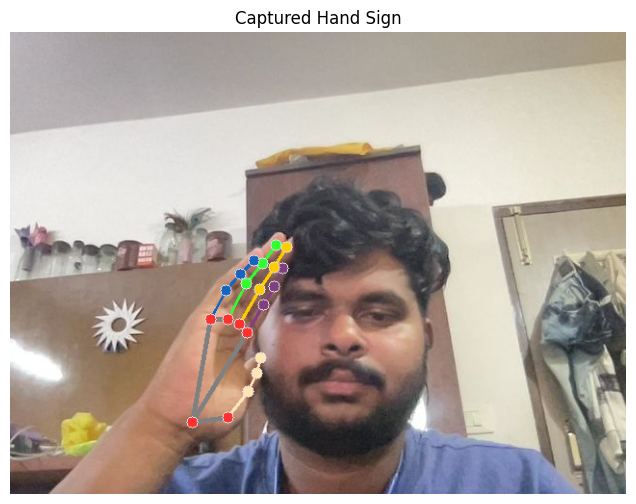


✅ Correct! You signed the word correctly! 🎉
You signed: HELLO
In Hindi: नमस्ते
Confidence: 0.84

Explanation: हम किसी को अभिवादन करते समय 'हैलो' कहते हैं।

Continue to the next question? (yes/no): yes

Question 2 of 3

------------------------------------------------------------
📝 Question: यदि कोई आपको कुछ प्रदान करता है जो आप नहीं चाहते हैं, तो आप क्या कहते हैं?
Please show the answer (नहीं / NO) in ASL sign language.
------------------------------------------------------------

Please position your hand to show the answer in ASL.
Click 'Capture' when ready.



<IPython.core.display.Javascript object>

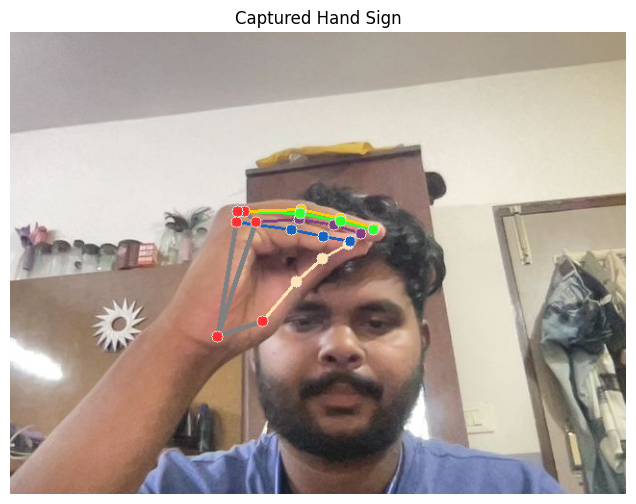


✅ Correct! You signed the word correctly! 🎉
You signed: NO
In Hindi: नहीं
Confidence: 0.84

Explanation: आप किसी प्रस्ताव को अस्वीकार करने के लिए 'नहीं' कहते हैं।

Continue to the next question? (yes/no): yes

Question 3 of 3

------------------------------------------------------------
📝 Question: बातचीत शुरू करने के लिए हम किस शब्द का उपयोग करते हैं?
Please show the answer (नमस्ते / HELLO) in ASL sign language.
------------------------------------------------------------

Please position your hand to show the answer in ASL.
Click 'Capture' when ready.



<IPython.core.display.Javascript object>

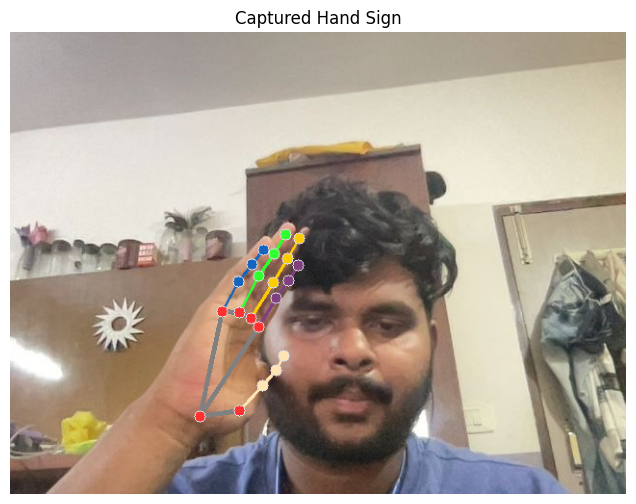


✅ Correct! You signed the word correctly! 🎉
You signed: HELLO
In Hindi: नमस्ते
Confidence: 0.62

Explanation: हम बातचीत शुरू करने के लिए 'हैलो' कहते हैं।

Quiz completed! Your score: 3/3

Thank you for using EduSign AI Word Quiz System! Keep practicing your ASL!


In [22]:
# Cell 9: Run the Quiz System
# --------------------------------
def main():
    print("\nChoose an option:")
    print("1. Run Sign Language Quiz")
    print("2. Use Text Translation Tool")

    choice = input("\nEnter choice (1-2): ")

    if choice == "2":
        translate_text_tool()
    else:
        # Initialize the quiz system
        quiz_system = EduSignQuizSystem()

        # Setup the system (train or load model)
        quiz_system.setup_system()

        # Run the quiz
        num_questions = 5
        try:
            user_questions = input(f"How many questions would you like? (default: {num_questions}): ")
            if user_questions.strip():
                num_questions = int(user_questions)
        except:
            # Keep default if invalid input
            pass

        quiz_system.run_quiz(num_questions=num_questions)

# Run the main function
if __name__ == "__main__":
    main()